In [88]:
# %pip install torch torch_geometric pytorch_lightning wandb scikit-learn matplotlib captum

In [89]:
import torch
from torch_geometric.data import Data
import pandas as pd
import wandb
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import numpy as np

pd.set_option('display.max_columns', None)

# Load the data

In [90]:
df = pd.read_csv('../get_lineup_target_score/nba_with_lineup_score.csv')
pre_df = pd.read_csv('../pre_season/pre_lineup_vs_lineup.csv')
pre_player_stats_df = pd.read_csv('../../data/player_stats_2023-24.csv')

In [97]:
def create_lineup_graph(df, pre_df, pre_player_stats_df):
    pre_df.fillna(0, inplace=True)
    df.dropna(subset=['net_score'], inplace=True)
    df = df[~df['net_score'].isin([np.inf, -np.inf])]

    all_lineups = pd.concat([df['home_lineup'], df['away_lineup']]).unique()
    pre_df_lineups = pd.concat([pre_df['home_lineup'], pre_df['away_lineup']]).unique()
    filtered_lineups = [lineup for lineup in all_lineups if lineup in pre_df_lineups]
    all_lineups = np.array(filtered_lineups)

    df = df[df['home_lineup'].isin(all_lineups) & df['away_lineup'].isin(all_lineups)]
    pre_df = pre_df[pre_df['home_lineup'].isin(all_lineups) & pre_df['away_lineup'].isin(all_lineups)]

    lineups_df = pd.DataFrame(all_lineups, columns=['lineup'])
    lineups_df["3pt_made"] = 0
    lineups_df["points"] = 0
    lineups_df["assists"] = 0
    lineups_df["def_rebounds"] = 0
    lineups_df["off_rebounds"] = 0
    lineups_df["fouls"] = 0
    lineups_df["2pt_made"] = 0
    lineups_df["turnovers"] = 0
    lineups_df["ft_made"] = 0
    lineups_df["steals"] = 0
    lineups_df["blocks"] = 0

    cols = ['3pt_made', 'points', 'assists', 'def_rebounds', 'off_rebounds', 'fouls', '2pt_made', 'turnovers', 'ft_made', 'steals', 'blocks']
    for index, row in pre_df.iterrows():
        home_lineup = row['home_lineup']
        away_lineup = row['away_lineup']
        
        for col in cols:
            home_col = 'home_' + col
            away_col = 'away_' + col
            if home_col in row and away_col in row:
                lineups_df.loc[lineups_df['lineup'] == home_lineup, col] += row[home_col]
                lineups_df.loc[lineups_df['lineup'] == away_lineup, col] += row[away_col]
            else:
                print(f'Column {home_col} or {away_col} not found in row')

    # Parse the lineup strings into tuples
    lineups_df['lineup_tuple'] = lineups_df['lineup'].apply(lambda x: ast.literal_eval(x))

    # Create a dictionary mapping player names to their stats
    player_stats_dict = pre_player_stats_df.set_index('PLAYER_NAME').to_dict('index')

    # Initialize columns for aggregated stats
    stat_columns = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV']
    for col in stat_columns:
        lineups_df[col] = 0

    num_lineups_to_not_aggregate = 0

    # Aggregate stats for each lineup
    for index, row in lineups_df.iterrows():
        lineup = row['lineup_tuple']
        for player in lineup:
            if player in player_stats_dict:
                player_stats = player_stats_dict[player]
                for col in stat_columns:
                    lineups_df.at[index, col] += player_stats.get(col, 0)
            else:
                # Delete the lineup if any player is not found in player stats
                lineups_df.drop(index=index, inplace=True)
                num_lineups_to_not_aggregate += 1
                break
    lineups_df.reset_index(drop=True, inplace=True)
    df = df[df['home_lineup'].isin(lineups_df['lineup']) & df['away_lineup'].isin(lineups_df['lineup'])]
    df.reset_index(drop=True, inplace=True)

    # Normalize the specified columns
    for col in stat_columns:
        max_value = lineups_df[col].max()
        if max_value > 0:  # Avoid division by zero
            lineups_df[col] = lineups_df[col] / max_value

    lineups_df.drop(columns=['lineup_tuple'], inplace=True)
    
    # Create unique lineup nodes
    lineup2idx = {lineup: idx for idx, lineup in enumerate(lineups_df['lineup'])}
    
    # Create node features based on lineups_df
    x = torch.tensor(lineups_df.iloc[:, 1:].values, dtype=torch.float)
    
    # Create directed edges with score-based direction
    edge_index = []
    edge_attr = []
    
    for _, row in df.iterrows():
        home = row['home_lineup']
        away = row['away_lineup']
        home_idx = lineup2idx[home]
        away_idx = lineup2idx[away]
        
        # Determine edge direction based on normalized scores
        if row['normalized_home_score'] > row['normalized_away_score']:
            src, dst = home_idx, away_idx
        else:
            src, dst = away_idx, home_idx
            
        edge_index.append([src, dst])
        edge_attr.append(abs(row['net_score']))
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1)
    
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=len(lineups_df))

In [98]:
data = create_lineup_graph(df, pre_df, pre_player_stats_df)

In [99]:
data

Data(x=[844, 17], edge_index=[2, 696], edge_attr=[696, 1], num_nodes=844)

# GNN Model

In [100]:
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GINEConv
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, AUROC, F1Score, Precision, Recall
from model import LitGNN

In [101]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, num_layers, hidden_dim, dropout_rate):
        super().__init__()
        self.convs = nn.ModuleList()
        self.dropout_rate = dropout_rate
        for _ in range(num_layers):
            conv = GINEConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                ),
                train_eps=True,
                edge_dim=1,
            )
            self.convs.append(conv)
            input_dim = hidden_dim
    
    def forward(self, x, edge_index, edge_attr):
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        return x

# Link Prediction Decoder with Edge Attributes
class LinkPredictor(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        mlp_layers = []
        current_dim = 2 * hidden_dim
        for _ in range(num_layers):
            mlp_layers.append(nn.Linear(current_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            current_dim = hidden_dim
        mlp_layers.append(nn.Linear(hidden_dim, 1))
        mlp_layers.append(nn.Sigmoid())
        self.mlp = nn.Sequential(*mlp_layers)
    
    def forward(self, u_emb, v_emb):
        concatenated = torch.cat([u_emb, v_emb], dim=1)
        return self.mlp(concatenated).squeeze()

# Lightning Module for Training
class LitGNN1(pl.LightningModule):
    def __init__(self,
                input_dim,
                # Conv layer parameters
                conv_layers=2,
                conv_hidden_dim=64,
                # Link prediction parameters
                link_predictor_layers=1,
                link_hidden_dim=64,
                # Training parameters
                learning_rate=0.001,
                weight_decay=0.0001,
                dropout_rate=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.gnn = GNNModel(input_dim, conv_layers, conv_hidden_dim, dropout_rate)
        self.link_predictor = LinkPredictor(link_predictor_layers, link_hidden_dim)
        self.loss_fn = nn.BCELoss()

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # Initialize metrics
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')
        self.train_auroc = AUROC(task='binary')
        self.val_auroc = AUROC(task='binary')
        self.test_auroc = AUROC(task='binary')
    
    def forward(self, x, edge_index, edge_attr):
        return self.gnn(x, edge_index, edge_attr)
    
    def training_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('train_loss', loss, prog_bar=True)
        # print(f"Train Loss: {loss:.4f}")

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.train_acc(preds_binary, edge_label.int())
        self.log('train_acc', acc, prog_bar=True)
        # print(f"Train Accuracy: {acc:.4f}")

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:
            auc = self.train_auroc(preds, edge_label.int())
            self.log('train_auc', auc, prog_bar=True)
            # print(f"Train AUC: {auc:.4f}")

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('val_loss', loss, prog_bar=True)

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.val_acc(preds_binary, edge_label.int())
        self.log('val_acc', acc, prog_bar=True)

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:  # Ensure both classes are present
            auc = self.val_auroc(preds, edge_label.int())
            self.log('val_auc', auc, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr
        edge_label_index, edge_label = batch.edge_label_index, batch.edge_label

        node_emb = self.gnn(x, edge_index, edge_attr)
        u_emb = node_emb[edge_label_index[0]]
        v_emb = node_emb[edge_label_index[1]]
        preds = self.link_predictor(u_emb, v_emb)

        loss = self.loss_fn(preds, edge_label.float())
        self.log('test_loss', loss, prog_bar=True)

        # Calculate accuracy
        preds_binary = (preds > 0.5).int()
        acc = self.test_acc(preds_binary, edge_label.int())
        self.log('test_acc', acc, prog_bar=True)

        # Calculate AUC-ROC
        if len(torch.unique(edge_label)) > 1:
            auc = self.test_auroc(preds, edge_label.int())
            self.log('test_auc', auc, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

In [102]:
# Function to add reversed edges as negatives to a Data object
def add_reversed_negatives(data):
    if data.edge_index.size(1) == 0:
        return data  # Skip if no edges
    original_edges = data.edge_index
    reversed_edges = torch.flip(original_edges, dims=[0])
    
    # Combine original and reversed edges
    edge_label_index = torch.cat([original_edges, reversed_edges], dim=1)
    edge_label = torch.cat([
        torch.ones(original_edges.size(1)),
        torch.zeros(reversed_edges.size(1))
    ])
    
    # Use original edge_attr for both directions
    edge_label_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0)
    
    # Shuffle the combined data
    perm = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, perm]
    edge_label_attr = edge_label_attr[perm]
    edge_label = edge_label[perm]
    
    data.edge_label_index = edge_label_index
    data.edge_label_attr = edge_label_attr
    data.edge_label = edge_label
    return data

In [103]:
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

In [104]:
model = LitGNN(input_dim=data.x.shape[1])

trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.8 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | val_acc        | BinaryAccuracy | 0      | train
5 | test_acc       | BinaryAccuracy | 0      | train
6 | train_auroc    | BinaryAUROC    | 0      | train
7 | val_auroc      | BinaryAUROC    | 0      | train
8 | test_auroc     | BinaryAUROC    | 0      | train
----------------------------------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.088     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 844. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s, v_num=82, train_loss=0.707, train_acc=0.502, train_auc=0.533, val_loss=0.686, val_acc=0.530, val_auc=0.666]

Metric val_loss improved. New best score: 0.686


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s, v_num=82, train_loss=0.684, train_acc=0.585, train_auc=0.640, val_loss=0.679, val_acc=0.593, val_auc=0.740]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.679


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s, v_num=82, train_loss=0.682, train_acc=0.599, train_auc=0.678, val_loss=0.672, val_acc=0.616, val_auc=0.754]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.672


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=82, train_loss=0.694, train_acc=0.599, train_auc=0.670, val_loss=0.667, val_acc=0.626, val_auc=0.760]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.667


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s, v_num=82, train_loss=0.682, train_acc=0.635, train_auc=0.711, val_loss=0.664, val_acc=0.659, val_auc=0.760]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.664


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s, v_num=82, train_loss=0.665, train_acc=0.678, train_auc=0.747, val_loss=0.661, val_acc=0.676, val_auc=0.759]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.661


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s, v_num=82, train_loss=0.725, train_acc=0.662, train_auc=0.727, val_loss=0.659, val_acc=0.681, val_auc=0.760]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.659


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s, v_num=82, train_loss=0.704, train_acc=0.664, train_auc=0.716, val_loss=0.658, val_acc=0.686, val_auc=0.760]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.658


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s, v_num=82, train_loss=0.663, train_acc=0.660, train_auc=0.705, val_loss=0.656, val_acc=0.701, val_auc=0.761]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.656


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s, v_num=82, train_loss=0.675, train_acc=0.711, train_auc=0.758, val_loss=0.654, val_acc=0.723, val_auc=0.761]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.654


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s, v_num=82, train_loss=0.691, train_acc=0.683, train_auc=0.719, val_loss=0.652, val_acc=0.730, val_auc=0.761]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.652


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=82, train_loss=0.653, train_acc=0.710, train_auc=0.753, val_loss=0.650, val_acc=0.729, val_auc=0.761]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.650


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=82, train_loss=0.651, train_acc=0.728, train_auc=0.754, val_loss=0.648, val_acc=0.728, val_auc=0.762]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.648


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=82, train_loss=0.642, train_acc=0.709, train_auc=0.757, val_loss=0.645, val_acc=0.728, val_auc=0.764]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.645


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, v_num=82, train_loss=0.655, train_acc=0.721, train_auc=0.743, val_loss=0.641, val_acc=0.728, val_auc=0.767]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.641


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s, v_num=82, train_loss=0.668, train_acc=0.727, train_auc=0.739, val_loss=0.637, val_acc=0.729, val_auc=0.771]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.637


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, v_num=82, train_loss=0.645, train_acc=0.717, train_auc=0.745, val_loss=0.633, val_acc=0.736, val_auc=0.775]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.633


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=82, train_loss=0.649, train_acc=0.723, train_auc=0.739, val_loss=0.629, val_acc=0.737, val_auc=0.779]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.629


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s, v_num=82, train_loss=0.658, train_acc=0.722, train_auc=0.739, val_loss=0.625, val_acc=0.728, val_auc=0.783]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.625


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s, v_num=82, train_loss=0.643, train_acc=0.721, train_auc=0.762, val_loss=0.621, val_acc=0.733, val_auc=0.786]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.621


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s, v_num=82, train_loss=0.648, train_acc=0.708, train_auc=0.731, val_loss=0.616, val_acc=0.737, val_auc=0.791]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.616


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s, v_num=82, train_loss=0.615, train_acc=0.732, train_auc=0.778, val_loss=0.611, val_acc=0.736, val_auc=0.793]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.611


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s, v_num=82, train_loss=0.640, train_acc=0.718, train_auc=0.738, val_loss=0.607, val_acc=0.735, val_auc=0.798]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.607


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s, v_num=82, train_loss=0.627, train_acc=0.723, train_auc=0.766, val_loss=0.602, val_acc=0.735, val_auc=0.801]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.602


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s, v_num=82, train_loss=0.624, train_acc=0.721, train_auc=0.768, val_loss=0.596, val_acc=0.735, val_auc=0.802]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.596


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s, v_num=82, train_loss=0.623, train_acc=0.720, train_auc=0.746, val_loss=0.590, val_acc=0.740, val_auc=0.804]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.590


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s, v_num=82, train_loss=0.617, train_acc=0.727, train_auc=0.765, val_loss=0.585, val_acc=0.741, val_auc=0.807]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.585


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s, v_num=82, train_loss=0.606, train_acc=0.728, train_auc=0.767, val_loss=0.578, val_acc=0.746, val_auc=0.808]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.578


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, v_num=82, train_loss=0.590, train_acc=0.758, train_auc=0.805, val_loss=0.572, val_acc=0.745, val_auc=0.810]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.572


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, v_num=82, train_loss=0.616, train_acc=0.735, train_auc=0.762, val_loss=0.565, val_acc=0.746, val_auc=0.814]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.565


Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s, v_num=82, train_loss=0.582, train_acc=0.737, train_auc=0.786, val_loss=0.559, val_acc=0.745, val_auc=0.818]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.559


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=82, train_loss=0.586, train_acc=0.727, train_auc=0.780, val_loss=0.553, val_acc=0.751, val_auc=0.824]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.553


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s, v_num=82, train_loss=0.602, train_acc=0.737, train_auc=0.769, val_loss=0.548, val_acc=0.752, val_auc=0.828]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.548


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, v_num=82, train_loss=0.569, train_acc=0.740, train_auc=0.797, val_loss=0.543, val_acc=0.751, val_auc=0.830]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.543


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 17.60it/s, v_num=82, train_loss=0.549, train_acc=0.761, train_auc=0.815, val_loss=0.538, val_acc=0.752, val_auc=0.830]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.538


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s, v_num=82, train_loss=0.554, train_acc=0.746, train_auc=0.816, val_loss=0.533, val_acc=0.752, val_auc=0.830]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.533


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s, v_num=82, train_loss=0.549, train_acc=0.738, train_auc=0.808, val_loss=0.529, val_acc=0.753, val_auc=0.831]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.529


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, v_num=82, train_loss=0.552, train_acc=0.726, train_auc=0.795, val_loss=0.527, val_acc=0.751, val_auc=0.831]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.527


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, v_num=82, train_loss=0.556, train_acc=0.747, train_auc=0.811, val_loss=0.525, val_acc=0.747, val_auc=0.833]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.525


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s, v_num=82, train_loss=0.566, train_acc=0.737, train_auc=0.788, val_loss=0.524, val_acc=0.746, val_auc=0.833]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.524


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s, v_num=82, train_loss=0.535, train_acc=0.730, train_auc=0.817, val_loss=0.520, val_acc=0.758, val_auc=0.837]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.520


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, v_num=82, train_loss=0.550, train_acc=0.742, train_auc=0.810, val_loss=0.516, val_acc=0.759, val_auc=0.839]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.516


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s, v_num=82, train_loss=0.527, train_acc=0.757, train_auc=0.827, val_loss=0.510, val_acc=0.759, val_auc=0.841]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.510


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, v_num=82, train_loss=0.524, train_acc=0.736, train_auc=0.821, val_loss=0.504, val_acc=0.761, val_auc=0.843]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.504


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s, v_num=82, train_loss=0.531, train_acc=0.747, train_auc=0.814, val_loss=0.500, val_acc=0.759, val_auc=0.845]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.500


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s, v_num=82, train_loss=0.537, train_acc=0.753, train_auc=0.819, val_loss=0.496, val_acc=0.760, val_auc=0.847]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.496


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, v_num=82, train_loss=0.532, train_acc=0.764, train_auc=0.828, val_loss=0.492, val_acc=0.758, val_auc=0.849]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.492


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, v_num=82, train_loss=0.504, train_acc=0.740, train_auc=0.837, val_loss=0.488, val_acc=0.756, val_auc=0.852]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.488


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s, v_num=82, train_loss=0.505, train_acc=0.756, train_auc=0.836, val_loss=0.484, val_acc=0.758, val_auc=0.854]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.484


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=82, train_loss=0.525, train_acc=0.746, train_auc=0.820, val_loss=0.480, val_acc=0.758, val_auc=0.857]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.480


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s, v_num=82, train_loss=0.519, train_acc=0.752, train_auc=0.829, val_loss=0.477, val_acc=0.758, val_auc=0.860]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.477


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s, v_num=82, train_loss=0.506, train_acc=0.761, train_auc=0.840, val_loss=0.474, val_acc=0.760, val_auc=0.863]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.474


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s, v_num=82, train_loss=0.509, train_acc=0.761, train_auc=0.836, val_loss=0.472, val_acc=0.760, val_auc=0.865]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.472


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s, v_num=82, train_loss=0.516, train_acc=0.751, train_auc=0.828, val_loss=0.471, val_acc=0.767, val_auc=0.868]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.471


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=82, train_loss=0.485, train_acc=0.769, train_auc=0.856, val_loss=0.467, val_acc=0.769, val_auc=0.871]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.467


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, v_num=82, train_loss=0.503, train_acc=0.746, train_auc=0.839, val_loss=0.466, val_acc=0.772, val_auc=0.873]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.466


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s, v_num=82, train_loss=0.494, train_acc=0.761, train_auc=0.849, val_loss=0.463, val_acc=0.773, val_auc=0.875]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.463


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s, v_num=82, train_loss=0.517, train_acc=0.736, train_auc=0.825, val_loss=0.460, val_acc=0.775, val_auc=0.877]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.460


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s, v_num=82, train_loss=0.480, train_acc=0.754, train_auc=0.850, val_loss=0.456, val_acc=0.776, val_auc=0.878]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.456


Epoch 63: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s, v_num=82, train_loss=0.498, train_acc=0.752, train_auc=0.839, val_loss=0.451, val_acc=0.777, val_auc=0.879]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.451


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s, v_num=82, train_loss=0.490, train_acc=0.745, train_auc=0.848, val_loss=0.447, val_acc=0.779, val_auc=0.881]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.447


Epoch 65: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s, v_num=82, train_loss=0.463, train_acc=0.755, train_auc=0.862, val_loss=0.440, val_acc=0.779, val_auc=0.882]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.440


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s, v_num=82, train_loss=0.463, train_acc=0.750, train_auc=0.859, val_loss=0.432, val_acc=0.773, val_auc=0.883]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.432


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s, v_num=82, train_loss=0.477, train_acc=0.763, train_auc=0.856, val_loss=0.425, val_acc=0.772, val_auc=0.884]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.425


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, v_num=82, train_loss=0.475, train_acc=0.769, train_auc=0.859, val_loss=0.422, val_acc=0.772, val_auc=0.886]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.422


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s, v_num=82, train_loss=0.477, train_acc=0.751, train_auc=0.858, val_loss=0.419, val_acc=0.773, val_auc=0.888]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.419


Epoch 75: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s, v_num=82, train_loss=0.452, train_acc=0.759, train_auc=0.863, val_loss=0.415, val_acc=0.788, val_auc=0.896]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.415


Epoch 76: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s, v_num=82, train_loss=0.443, train_acc=0.778, train_auc=0.872, val_loss=0.408, val_acc=0.785, val_auc=0.897]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.408


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s, v_num=82, train_loss=0.446, train_acc=0.759, train_auc=0.868, val_loss=0.402, val_acc=0.788, val_auc=0.899]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.402


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s, v_num=82, train_loss=0.428, train_acc=0.754, train_auc=0.873, val_loss=0.395, val_acc=0.792, val_auc=0.900]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.395


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=82, train_loss=0.432, train_acc=0.783, train_auc=0.879, val_loss=0.390, val_acc=0.790, val_auc=0.901]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.390


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s, v_num=82, train_loss=0.404, train_acc=0.786, train_auc=0.892, val_loss=0.385, val_acc=0.793, val_auc=0.903]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.385


Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s, v_num=82, train_loss=0.403, train_acc=0.779, train_auc=0.888, val_loss=0.379, val_acc=0.792, val_auc=0.905]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.379


Epoch 82: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s, v_num=82, train_loss=0.423, train_acc=0.766, train_auc=0.878, val_loss=0.374, val_acc=0.797, val_auc=0.907]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.374


Epoch 83: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s, v_num=82, train_loss=0.411, train_acc=0.782, train_auc=0.886, val_loss=0.370, val_acc=0.797, val_auc=0.910]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.370


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s, v_num=82, train_loss=0.417, train_acc=0.772, train_auc=0.880, val_loss=0.368, val_acc=0.805, val_auc=0.913]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.368


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s, v_num=82, train_loss=0.411, train_acc=0.754, train_auc=0.878, val_loss=0.367, val_acc=0.807, val_auc=0.916]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.367


Epoch 93: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=82, train_loss=0.377, train_acc=0.782, train_auc=0.892, val_loss=0.359, val_acc=0.818, val_auc=0.924]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.359


Epoch 94: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, v_num=82, train_loss=0.376, train_acc=0.792, train_auc=0.901, val_loss=0.349, val_acc=0.824, val_auc=0.926]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.349


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=82, train_loss=0.364, train_acc=0.795, train_auc=0.905, val_loss=0.340, val_acc=0.823, val_auc=0.927]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.340


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s, v_num=82, train_loss=0.368, train_acc=0.784, train_auc=0.900, val_loss=0.333, val_acc=0.821, val_auc=0.929]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.333


Epoch 97: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s, v_num=82, train_loss=0.396, train_acc=0.784, train_auc=0.895, val_loss=0.331, val_acc=0.821, val_auc=0.930]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.331


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s, v_num=82, train_loss=0.349, train_acc=0.804, train_auc=0.912, val_loss=0.330, val_acc=0.821, val_auc=0.932]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.330


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s, v_num=82, train_loss=0.346, train_acc=0.824, train_auc=0.921, val_loss=0.321, val_acc=0.821, val_auc=0.933]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.321


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s, v_num=82, train_loss=0.351, train_acc=0.796, train_auc=0.909, val_loss=0.315, val_acc=0.820, val_auc=0.933]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.315


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, v_num=82, train_loss=0.335, train_acc=0.804, train_auc=0.916, val_loss=0.311, val_acc=0.816, val_auc=0.934]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.311


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s, v_num=82, train_loss=0.334, train_acc=0.812, train_auc=0.918, val_loss=0.310, val_acc=0.820, val_auc=0.936]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.310


Epoch 117: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s, v_num=82, train_loss=0.327, train_acc=0.822, train_auc=0.925, val_loss=0.300, val_acc=0.833, val_auc=0.939]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.300


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s, v_num=82, train_loss=0.342, train_acc=0.796, train_auc=0.912, val_loss=0.294, val_acc=0.832, val_auc=0.939]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.294


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s, v_num=82, train_loss=0.305, train_acc=0.815, train_auc=0.931, val_loss=0.287, val_acc=0.834, val_auc=0.939]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.287


Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s, v_num=82, train_loss=0.326, train_acc=0.815, train_auc=0.921, val_loss=0.286, val_acc=0.838, val_auc=0.939]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.286


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s, v_num=82, train_loss=0.315, train_acc=0.816, train_auc=0.923, val_loss=0.286, val_acc=0.837, val_auc=0.942]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.286


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s, v_num=82, train_loss=0.315, train_acc=0.818, train_auc=0.924, val_loss=0.285, val_acc=0.841, val_auc=0.943]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.285


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s, v_num=82, train_loss=0.311, train_acc=0.807, train_auc=0.926, val_loss=0.280, val_acc=0.840, val_auc=0.943]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.280


Epoch 144: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, v_num=82, train_loss=0.292, train_acc=0.832, train_auc=0.938, val_loss=0.279, val_acc=0.846, val_auc=0.944]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.279


Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, v_num=82, train_loss=0.303, train_acc=0.821, train_auc=0.929, val_loss=0.276, val_acc=0.841, val_auc=0.945]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.276


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s, v_num=82, train_loss=0.309, train_acc=0.817, train_auc=0.925, val_loss=0.272, val_acc=0.842, val_auc=0.944]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.272


Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s, v_num=82, train_loss=0.275, train_acc=0.837, train_auc=0.942, val_loss=0.272, val_acc=0.846, val_auc=0.946]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.272


Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s, v_num=82, train_loss=0.301, train_acc=0.830, train_auc=0.934, val_loss=0.271, val_acc=0.846, val_auc=0.946]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.271


Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s, v_num=82, train_loss=0.292, train_acc=0.829, train_auc=0.935, val_loss=0.270, val_acc=0.843, val_auc=0.948]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.270


Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s, v_num=82, train_loss=0.294, train_acc=0.819, train_auc=0.929, val_loss=0.269, val_acc=0.841, val_auc=0.948]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.269


Epoch 175: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s, v_num=82, train_loss=0.282, train_acc=0.831, train_auc=0.937, val_loss=0.269, val_acc=0.841, val_auc=0.948]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.269


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s, v_num=82, train_loss=0.280, train_acc=0.828, train_auc=0.939, val_loss=0.269, val_acc=0.847, val_auc=0.950]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.269


Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s, v_num=82, train_loss=0.286, train_acc=0.825, train_auc=0.936, val_loss=0.268, val_acc=0.847, val_auc=0.950]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.268


Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s, v_num=82, train_loss=0.291, train_acc=0.815, train_auc=0.932, val_loss=0.267, val_acc=0.849, val_auc=0.950]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.267


Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s, v_num=82, train_loss=0.277, train_acc=0.825, train_auc=0.939, val_loss=0.265, val_acc=0.846, val_auc=0.950]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.265


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, v_num=82, train_loss=0.274, train_acc=0.832, train_auc=0.941, val_loss=0.261, val_acc=0.844, val_auc=0.948]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.261


Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s, v_num=82, train_loss=0.287, train_acc=0.827, train_auc=0.935, val_loss=0.261, val_acc=0.843, val_auc=0.947]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.261


Epoch 198: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s, v_num=82, train_loss=0.283, train_acc=0.831, train_auc=0.935, val_loss=0.260, val_acc=0.838, val_auc=0.949]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.260


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s, v_num=82, train_loss=0.265, train_acc=0.834, train_auc=0.943, val_loss=0.259, val_acc=0.839, val_auc=0.948]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.259


Epoch 200: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s, v_num=82, train_loss=0.279, train_acc=0.840, train_auc=0.941, val_loss=0.259, val_acc=0.839, val_auc=0.948]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.259


Epoch 208: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s, v_num=82, train_loss=0.283, train_acc=0.837, train_auc=0.942, val_loss=0.256, val_acc=0.849, val_auc=0.952]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.256


Epoch 209: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s, v_num=82, train_loss=0.262, train_acc=0.858, train_auc=0.950, val_loss=0.253, val_acc=0.849, val_auc=0.952]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.253


Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s, v_num=82, train_loss=0.284, train_acc=0.841, train_auc=0.943, val_loss=0.253, val_acc=0.849, val_auc=0.954]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.253. Signaling Trainer to stop.


Epoch 219: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=82, train_loss=0.284, train_acc=0.841, train_auc=0.943, val_loss=0.253, val_acc=0.849, val_auc=0.954]


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8110047578811646
        test_auc            0.9290741682052612
        test_loss           0.29970279335975647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.29970279335975647,
  'test_acc': 0.8110047578811646,
  'test_auc': 0.9290741682052612}]

# Evaluation

In [53]:
sweep_config = {
    'method': 'bayes',  # bayes, grid, or random
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'   
    },
    'parameters': {
        'hidden_dim': {
            'values': [32, 64, 128]
        },
        'num_conv_layers': {
            'values': [2, 3, 4]
        },
        'num_linear_layers': {
            'values': [1, 2, 3]
        },
        'lr': {
            'distribution': 'log_uniform_values',
            'min': 1e-4,
            'max': 1e-2
        },
        'weight_decay': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-2
        },
        'dropout': {
            'values': [0.0, 0.2, 0.4]
        }
    }
}

In [54]:
def train_sweep():
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    with wandb.init() as run:
        config = wandb.config

        # Log the hyperparameters
        wandb.log({
            "num_conv_layers": config.num_conv_layers,
            "num_linear_layers": config.num_linear_layers,
            "hidden_dim": config.hidden_dim,
            "lr": config.lr,
            "weight_decay": config.weight_decay,
            "dropout": config.dropout
        })
        
        # Initialize the model
        model = LitGNN(
            input_dim=data.x.shape[1],
            conv_layers=config.num_conv_layers,
            link_predictor_layers=config.num_linear_layers,
            conv_hidden_dim=config.hidden_dim,
            link_hidden_dim=config.hidden_dim,
            learning_rate=config.lr,
            weight_decay=config.weight_decay,
            dropout_rate=config.dropout
        )
        
        trainer = pl.Trainer(
            max_epochs=200,
            logger=pl.loggers.WandbLogger(),
            callbacks=[
                pl.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                pl.callbacks.ModelCheckpoint(monitor='val_loss')
            ]
        )
        trainer.fit(model, train_loader, val_loader)
        trainer.test(model, test_loader)

In [55]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="nba_lineup_prediction")
# Start the sweep agent
# wandb.agent(sweep_id, function=train_sweep, count=20)  # Run 5 agents in parallel

Create sweep with ID: w1im1igc
Sweep URL: https://wandb.ai/rokaati18-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem/nba_lineup_prediction/sweeps/w1im1igc


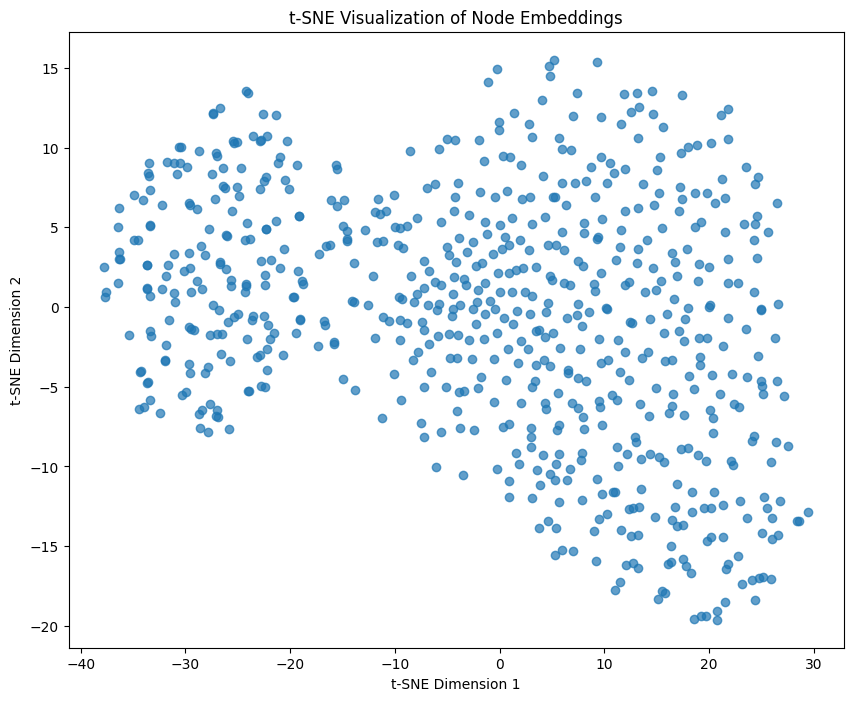

In [57]:
# Get the node embeddings from the model
node_embeddings = model.gnn(data.x, data.edge_index, data.edge_attr)
# Visualize the embeddings
visualize_embeddings_tsne(node_embeddings)

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


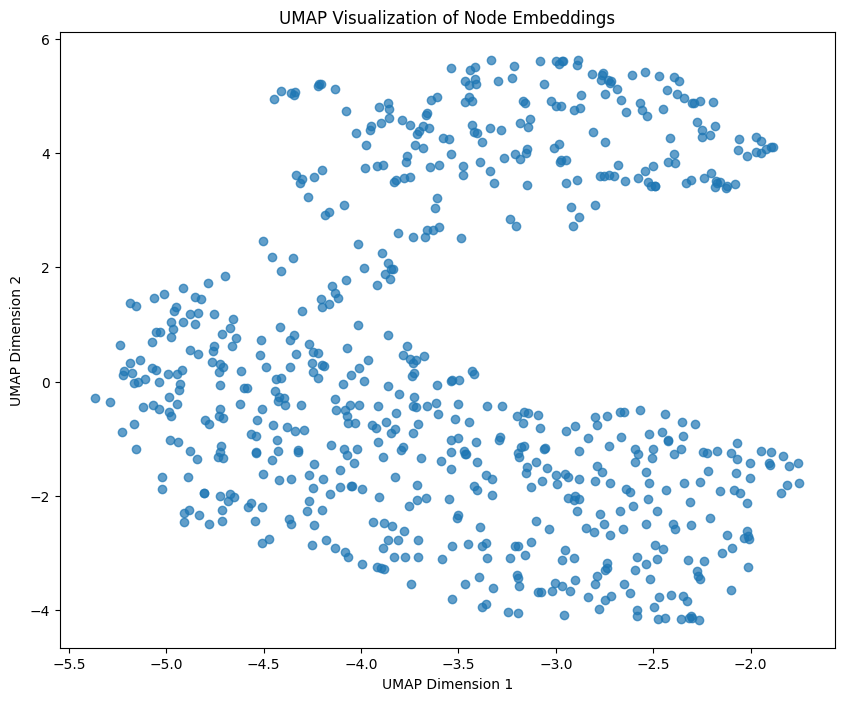

In [59]:
visualize_embeddings_umap(node_embeddings)